In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import imshow
import numpy as np
import glob
import matplotlib.animation as animation
import re
import math
plt.style.use('seaborn')
%config Completer.use_jedi = False
%matplotlib inline

In [22]:
from astropy.io import fits 
from astropy.io.fits import getdata
from astropy.visualization import astropy_mpl_style
from photutils import CircularAperture ,aperture_photometry,CircularAnnulus
from photutils.datasets import make_100gaussians_image
from astropy.stats import sigma_clipped_stats
from astropy.time import Time
import scipy.interpolate as sc
from urllib.request import urlopen
from bs4 import BeautifulSoup
from astropy.timeseries import LombScargle
import astropy.units as u
from astropy.time import TimeDelta
import julian
import datetime

In [3]:
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    cols = df.columns.tolist()    
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

# File handling and Date collection

In [4]:
files = glob.glob('*.fits')
files.sort()
files[0:10]

['ceph_2451890.76992.fits',
 'ceph_2451890.79772.fits',
 'ceph_2451890.82012.fits',
 'ceph_2451890.84782.fits',
 'ceph_2451890.87572.fits',
 'ceph_2451890.90352.fits',
 'ceph_2451890.97072.fits',
 'ceph_2451891.31132.fits',
 'ceph_2451891.35292.fits',
 'ceph_2451891.35562.fits']

In [5]:
hdu=fits.open(files[0])
gain=hdu[0].header['GAINCCD']
exp_time=hdu[0].header['TM-EXPOS']
print("Gain :",gain)
print("Time exposed :",exp_time)
hdu[0].header

Gain : 1.66
Time exposed : 300


 [astropy.io.fits.verify]


SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                  201 / Axis length                                    
NAXIS2  =                  201 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2007-06-14T01:41:26' / Date FITS file was generated                  
IRAF-TLM= '12:41:30 (14/06/2007)' / Time of last modification                   
OBJECT  = 'smc-lentilles'      / Name of the object observed                    
NUMCAM  =                    1                                                  
NUMCCD  =                    5                                                  
NUMADC  =                   

In [6]:
jddates=[]
isodates=[]
for name in files:
    k = re.findall('\d{7}[.]\d{5}',name)
    jddates.append(float(k
                         [0]))
    isodates.append(julian.from_jd(float(k[0]), fmt='jd'))
df=pd.DataFrame(isodates,columns=['Datetime'])



# Aperture Photometry

In [172]:
positions = [(101., 101.),(102.5,171.5),(138.,103)]#,(58,166)
ap = CircularAperture(positions, r=5.)
annulus_ap=CircularAnnulus(positions,r_in = 10.,r_out=12.)
annulus_masks = annulus_ap.to_mask(method='center')
aperture=[ap]


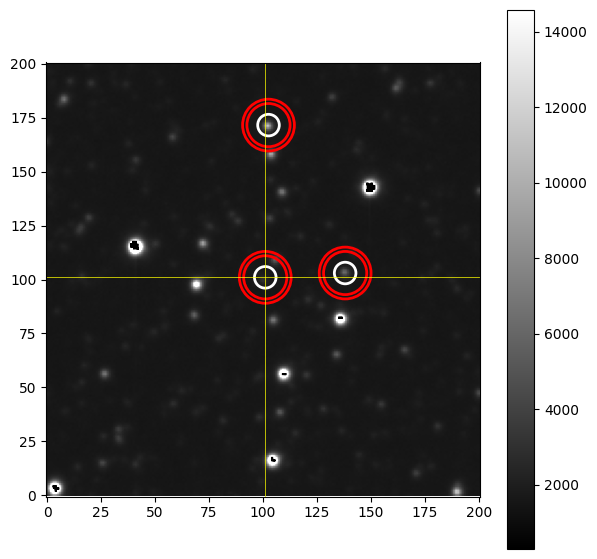

In [173]:
hdu=fits.open(files[14])
image = np.asarray(hdu[0].data)
images = np.array(image).astype(np.float64)

plt.figure(figsize=(7,7))
plt.imshow(images,vmin=np.median(image)-1*np.std(image),
               vmax=np.median(image)+10*np.std(image),cmap='gray',origin='lower')
ap.plot(color='white',lw=2)
plt.colorbar()
annulus_ap.plot(color='red',lw=2)
plt.axhline(y=101,color='yellow',lw=.5)
plt.axvline(x=101,color='yellow',lw=.5)

plt.show()


## Aperture Photometry

In [174]:
flux=0
cepheid_data=pd.DataFrame()
bgStar1_data=pd.DataFrame()
bgStar2_data=pd.DataFrame()
for i,f_name in enumerate(files):
    hdu=fits.open(f_name)
    image = np.asarray(hdu[0].data)
    
    annulus_data_ceph = annulus_masks[0].multiply(image)
    annulus_data1 = annulus_masks[1].multiply(image)
    annulus_data2 = annulus_masks[2].multiply(image)
    
    mask_ceph = annulus_masks[0].data
    mask1 = annulus_masks[1].data
    mask2 = annulus_masks[2].data
    
    annulus_1data_ceph = annulus_data_ceph[mask_ceph>0]
    annulus_1data1 = annulus_data1[mask1 > 0]
    annulus_1data2 = annulus_data2[mask2 > 0]
    
    median=[0,0,0]
    _, median[0] , _ = sigma_clipped_stats(annulus_1data_ceph)
    _, median[1] , _ = sigma_clipped_stats(annulus_1data1)
    _, median[2] , _ = sigma_clipped_stats(annulus_1data2)
    aperture=[ap]
    phot_table = aperture_photometry(image, aperture)
    phot_table['annulus_median']=median
    phot_table['aperture_bg']= np.array(median) * np.array(ap.area)
    phot_table['Corrected count']=phot_table['aperture_sum_0']-phot_table['aperture_bg']
    phot_table['Flux']=phot_table['Corrected count']*gain/exp_time
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    temptable=phot_table.to_pandas()
       
    cepheid_data=cepheid_data.append(temptable.iloc[0],ignore_index=True)
    bgStar1_data=bgStar1_data.append(temptable.iloc[1],ignore_index=True)
    bgStar2_data=bgStar2_data.append(temptable.iloc[2],ignore_index=True)
    hdu.close()
phot_table
cepheid_data.drop(['id','xcenter','ycenter'],axis=1,inplace=True)
bgStar1_data.drop(['id','xcenter','ycenter'],axis=1,inplace=True)
bgStar2_data.drop(['id','xcenter','ycenter'],axis=1,inplace=True)
cepheid_data['T_OBS']=isodates
bgStar1_data['T_OBS']=isodates
bgStar2_data['T_OBS']=isodates

flux=np.array(flux)

In [175]:
cepheid_data=movecol(cepheid_data,['T_OBS','annulus_median','aperture_bg','aperture_sum_0'],'Corrected count',place='Before')
bgStar1_data=movecol(bgStar1_data,['T_OBS','annulus_median','aperture_bg','aperture_sum_0'],'Corrected count',place='Before')
bgStar2_data=movecol(bgStar2_data,['T_OBS','annulus_median','aperture_bg','aperture_sum_0'],'Corrected count',place='Before')

cepheid_data['Inst_mag']=-2.5*np.log10(cepheid_data.Flux)
bgStar1_data['Inst_mag']=-2.5*np.log10(bgStar1_data.Flux)
bgStar2_data['Inst_mag']=-2.5*np.log10(bgStar2_data.Flux)


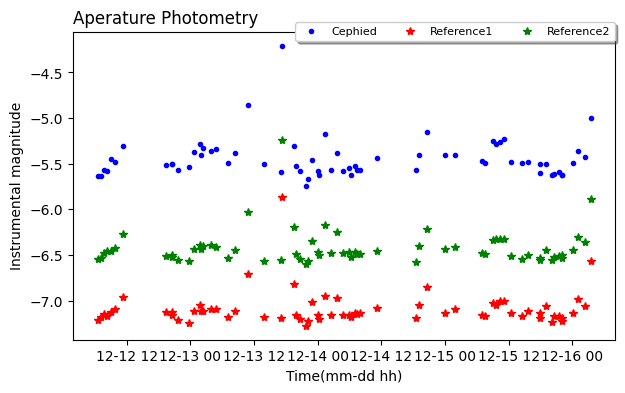

In [176]:
plt.figure(figsize=[7,4])
plt.plot(cepheid_data.T_OBS,cepheid_data.Inst_mag,'bo',markersize=3,label='Cephied')
plt.plot(bgStar1_data.T_OBS,bgStar1_data.Inst_mag,'r*',label='Reference1')
plt.plot(bgStar2_data.T_OBS,bgStar2_data.Inst_mag,'g*',label='Reference2')
plt.legend(loc='center left', bbox_to_anchor=(0.4, 1.),shadow=True, ncol=3, fontsize = 8)
plt.xlabel('Time(mm-dd hh)')
plt.ylabel('Instrumental magnitude')
plt.title("Aperature Photometry",loc='left')
plt.show()

## Differential Photometry

In [177]:
DIFF_PHOTtable=pd.DataFrame()
DIFF_PHOTtable['T_OBS']=isodates
DIFF_PHOTtable['T_OBS_JD']=jddates
DIFF_PHOTtable['Inst_mag_CEPH']=cepheid_data.Inst_mag
DIFF_PHOTtable['Inst_mag_Ref1']=bgStar1_data.Inst_mag
DIFF_PHOTtable['Inst_mag_Ref2']=bgStar2_data.Inst_mag
DIFF_PHOTtable['Diff_mag_CEPH']=DIFF_PHOTtable.Inst_mag_CEPH-DIFF_PHOTtable.Inst_mag_Ref2
DIFF_PHOTtable['Diff_mag_Ref1']=DIFF_PHOTtable.Inst_mag_Ref1-DIFF_PHOTtable.Inst_mag_Ref2
DIFF_PHOTtable['Diff_mag_Ref2']=DIFF_PHOTtable.Inst_mag_Ref2-DIFF_PHOTtable.Inst_mag_Ref2

In [178]:
DIFF_PHOTtable

,T_OBS,T_OBS_JD,Inst_mag_CEPH,Inst_mag_Ref1,Inst_mag_Ref2,Diff_mag_CEPH,Diff_mag_Ref1,Diff_mag_Ref2
0,2000-12-12 06:28:41.087989,2.451891e+06,-5.637695,-7.215196,-6.549151,0.911456,-0.666045,0.0
1,2000-12-12 07:08:43.008012,2.451891e+06,-5.635708,-7.180879,-6.537396,0.901689,-0.643483,0.0
2,2000-12-12 07:40:58.367983,2.451891e+06,-5.566007,-7.151581,-6.477506,0.911500,-0.674075,0.0
3,2000-12-12 08:20:51.647982,2.451891e+06,-5.575344,-7.165236,-6.456602,0.881257,-0.708635,0.0
4,2000-12-12 09:01:02.207990,2.451891e+06,-5.449870,-7.122659,-6.457486,1.007617,-0.665173,0.0
...,...,...,...,...,...,...,...,...
63,2000-12-15 22:07:33.888009,2.451894e+06,-5.623264,-7.224673,-6.532187,0.908923,-0.692486,0.0
64,2000-12-16 00:09:49.247980,2.451895e+06,-5.496010,-7.140624,-6.450312,0.954303,-0.690311,0.0
65,2000-12-16 01:06:59.327987,2.451895e+06,-5.365567,-6.985287,-6.299570,0.934003,-0.685717,0.0
66,2000-12-16 02:19:16.607982,2.451895e+06,-5.422229,-7.062297,-6.361008,0.938779,-0.701289,0.0


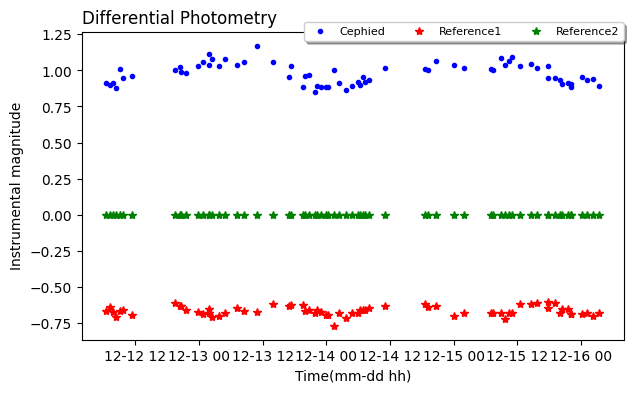

In [179]:
plt.figure(figsize=[7,4])
plt.style.use('default')
plt.plot(DIFF_PHOTtable.T_OBS,DIFF_PHOTtable.Diff_mag_CEPH,'bo',markersize=3,label='Cephied')
plt.plot(DIFF_PHOTtable.T_OBS,DIFF_PHOTtable.Diff_mag_Ref1,'r*',label='Reference1')
plt.plot(DIFF_PHOTtable.T_OBS,DIFF_PHOTtable.Diff_mag_Ref2,'g*',label='Reference2')
plt.legend(loc='center left', bbox_to_anchor=(0.4, 1.),shadow=True, ncol=3, fontsize = 8)
plt.xlabel('Time(mm-dd hh)')

plt.ylabel('Instrumental magnitude')
plt.title("Differential Photometry",loc='left')
plt.show()

## Apparent Magnitude Calculation

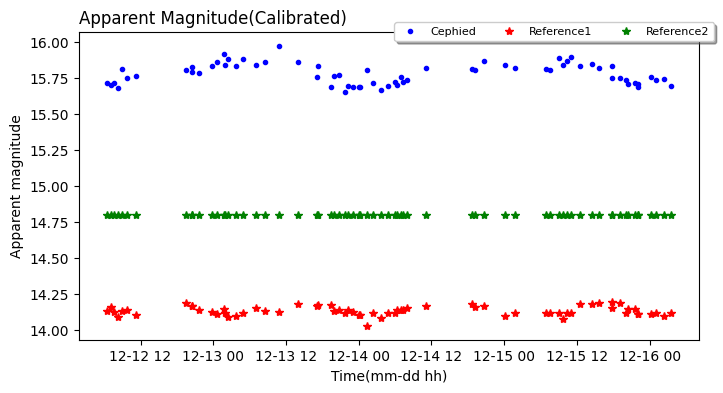

In [180]:
plt.figure(figsize=[8,4])
plt.style.use('default')
plt.plot(DIFF_PHOTtable.T_OBS,DIFF_PHOTtable.Diff_mag_CEPH+14.8,'bo',markersize=3,label='Cephied')
plt.plot(DIFF_PHOTtable.T_OBS,DIFF_PHOTtable.Diff_mag_Ref1+14.8,'r*',label='Reference1')
plt.plot(DIFF_PHOTtable.T_OBS,DIFF_PHOTtable.Diff_mag_Ref2+14.8,'g*',label='Reference2')
plt.legend(loc='center left', bbox_to_anchor=(0.5, 1.),shadow=True, ncol=3, fontsize = 8)
plt.xlabel('Time(mm-dd hh)',fontsize='10')

plt.ylabel('Apparent magnitude',fontsize='10')
plt.title("Apparent Magnitude(Calibrated)",loc='left',fontsize='12')
plt.show()

In [186]:
CEPH_AppMAG=np.median(DIFF_PHOTtable.Diff_mag_CEPH-DIFF_PHOTtable.Diff_mag_Ref1+14.8)
print('Apparent Magnitude : ',format(CEPH_AppMAG,"10.6"))

Apparent Magnitude :     16.4298


# LombScragle Periodgram(Period  estimation)

In [187]:
frequency, power = LombScargle(DIFF_PHOTtable.T_OBS_JD, DIFF_PHOTtable.Diff_mag_CEPH).autopower()

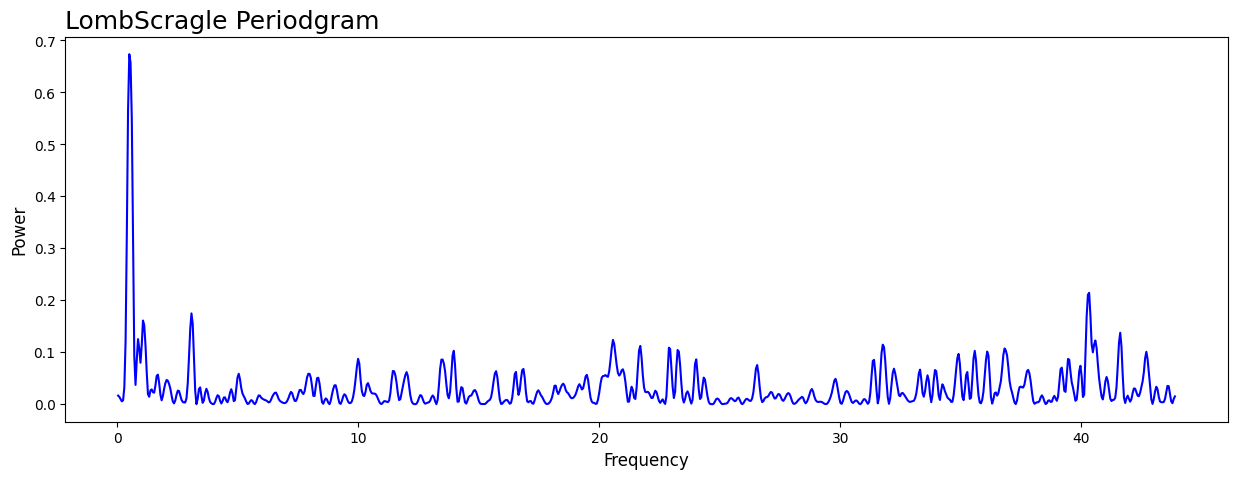

In [214]:
plt.figure(figsize=[15,5])
plt.plot(frequency, power,color='blue')
plt.title("LombScragle Periodgram",loc='left',fontsize='18')
plt.xlabel('Frequency',fontsize='12')
plt.ylabel('Power',fontsize='12')
plt.show()

In [189]:
best_frequency = frequency[np.argmax(power)]#+frequency[np.argmax(power)-1])/2

timep=TimeDelta(1/best_frequency, format='jd')
timep

<TimeDelta object: scale='None' format='jd' value=2.039736842148398>

In [190]:
print('Time period :',timep.datetime)

Time period : 2 days, 0:57:13.263162


# Period-luminosity relation

## Method 1:Given Data

In [191]:
dftrain = pd.read_csv("cepheids.csv")
X1=dftrain.logP
Y1=dftrain.M

In [192]:
linFIT1 = np.polyfit(X1,Y1,1)
linFIT1

array([-2.92474995, -1.18266198])

## Method 2: Data from David Dunlap Observatory  
https://www.astro.utoronto.ca/DDO/research/cepheids/table_physical.html

In [193]:
url = "https://www.astro.utoronto.ca/DDO/research/cepheids/table_physical.html"
page = urlopen(url)
html = page.read().decode("utf-8")
soup = BeautifulSoup(html, "html.parser")

In [194]:
testTXT=soup.getText()
testTXT=testTXT.replace(testTXT[0:190], '')
testTXT=testTXT.splitlines()
testTXT=testTXT[0:509]

In [195]:
chep_data=pd.DataFrame(columns=['Period','M'])
for l in testTXT:
    tempP=float(l[15:21])
    tempM=float(l[59:64])
    chep_data.loc[len(chep_data.index)] = [tempP,tempM] 
chep_data['logP']=np.log10(chep_data.Period)

In [196]:
chep_data['label']='N'
for i,row in chep_data.iterrows():
    if (row.M-(-row.logP*2.91-1.42)>0):
        chep_data.loc[chep_data.logP==row.logP,'label']='Type1'
    elif (row.M-(-row.logP*2.91-1.42)<0):
        chep_data.loc[chep_data.logP==row.logP,'label']='Type2'

In [197]:
X2_1=chep_data.loc[chep_data.label=='Type1'].logP
Y2_1=chep_data.loc[chep_data.label=='Type1'].M

X2_2=chep_data.loc[chep_data.label=='Type2'].logP
Y2_2=chep_data.loc[chep_data.label=='Type2'].M


In [198]:
linFIT2_1 = np.polyfit(X2_1,Y2_1,1) #Type1
linFIT2_2 = np.polyfit(X2_2,Y2_2,1) #Type2
print('Type I fit coefficients : ',linFIT2_1)
print('Type II fit coefficients : ',linFIT2_2)

Type I fit coefficients :  [-2.90242754 -1.20275849]
Type II fit coefficients :  [-2.9565874  -1.62209605]


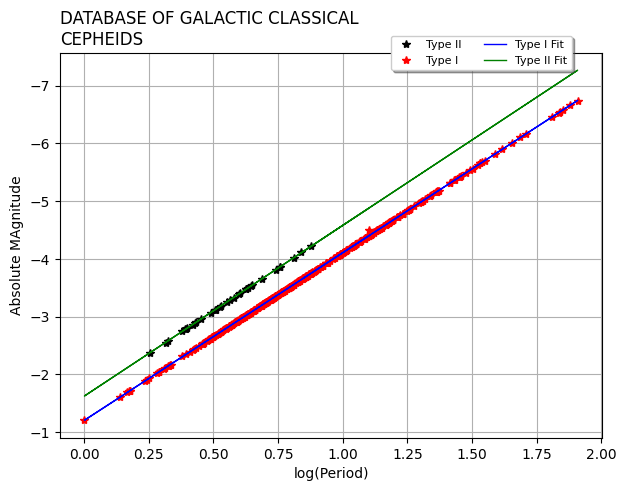

In [213]:
plt.figure(figsize=[7,5])
plt.style.use('default')
plt.grid()
plt.plot(X2_2,Y2_2,'k*',label='Type II')
plt.plot(X2_1,Y2_1,'r*',label='Type I')
plt.gca().invert_yaxis()
plt.plot(X2_1,linFIT2_1[0]*X2_1+linFIT2_1[1],c="blue",lw='1',label='Type I Fit')
plt.plot(X2_1,linFIT2_2[0]*X2_1+linFIT2_2[1],c="green",lw='1',label='Type II Fit')
plt.legend(loc='center left', bbox_to_anchor=(0.6, 1.),shadow=True, ncol=2, fontsize = 8)
plt.xlabel('log(Period)',fontsize=10)
plt.ylabel('Absolute MAgnitude',fontsize=10)
plt.title('DATABASE OF GALACTIC CLASSICAL \nCEPHEIDS',fontsize=12,loc='left')
#plt.plot(X2,-2.91*X2-1.42)
plt.show()

# Absolute magnitude and Distance Calculation

In [200]:
CEPH_AbsMag_1=np.polyval(linFIT1,np.log10(timep.sec/86400))
print('Absolute Magnitude(Calculated) with PLmethod1:',format(CEPH_AbsMag_1,"10.6"))
CEPH_AbsMag_2=np.polyval(linFIT2_1,np.log10(timep.sec/86400))
print('Absolute Magnitude(Calculated) with PLmethod2:',format(CEPH_AbsMag_2,"10.6"))

Absolute Magnitude(Calculated) with PLmethod1:   -2.08809
Absolute Magnitude(Calculated) with PLmethod2:   -2.10128


In [201]:
Dist1=10*10**((CEPH_AppMAG-CEPH_AbsMag_1)/5)
Dist2=10*10**((CEPH_AppMAG-CEPH_AbsMag_2)/5)

In [202]:
print('Distance Calculted with PLmethod1:',format(Dist1, "10.2E"),'pc')
print('Distance Calculted with PLmethod2:',format(Dist2, "10.2E"),'pc')

Distance Calculted with PLmethod1:   5.05E+04 pc
Distance Calculted with PLmethod2:   5.08E+04 pc


# Web scrapping( Cepheid data collection)
https://ogledb.astrouw.edu.pl/~ogle/OCVS/getobj.php?s=OGLE-SMC-CEP-2243&q=b55EYSpbTVI7ylfDaZzcO.Q4nQ6j.gvyuLC44i.xSfy4v5VMS3DMvrSBUtEJU_Pk28cHCBuWxww0rx8q1aZNA4MesiUMivcCedcTDJm6oPZBXIzCZbc5Cr3gvexfWHjJ8NLcvraqgzDi7Wf95kqLWhO9EoM-&pos=.qw9cenVmxb0GalvGPWszh8ugRshFfbIQJC8oWrc9TUAi1Suu0M.w9zokYMl0ONs5jk6jlAb7CDp7NM85UueCbcHNdax6hOBFHYzOXKxTpLbAQR3

In [203]:
url = "https://ogledb.astrouw.edu.pl/~ogle/OCVS/getobj.php?s=OGLE-SMC-CEP-2243&q=b55EYSpbTVI7ylfDaZzcO.Q4nQ6j.gvyuLC44i.xSfy4v5VMS3DMvrSBUtEJU_Pk28cHCBuWxww0rx8q1aZNA4MesiUMivcCedcTDJm6oPZBXIzCZbc5Cr3gvexfWHjJ8NLcvraqgzDi7Wf95kqLWhO9EoM-&pos=.qw9cenVmxb0GalvGPWszh8ugRshFfbIQJC8oWrc9TUAi1Suu0M.w9zokYMl0ONs5jk6jlAb7CDp7NM85UueCbcHNdax6hOBFHYzOXKxTpLbAQR3"
page = urlopen(url)
html = page.read().decode("utf-8")
soup = BeautifulSoup(html, "html.parser")

In [204]:
text=soup.getText()

In [209]:
Vnum=text.find('I =')+4
Pnum=text.find('P_1 = ')+6
Period_Actual=float(text[Pnum:Pnum+9])
AppMag_Actual=float(text[Vnum:Vnum+6])
AbsMag_Actual=np.polyval(linFIT2_1,np.log10(Period_Actual))

print("Actual Apparent Magnitude : ",AppMag_Actual)
print("Actual Period : ",Period_Actual)
print("Actual Absolute Magnitude : ",AbsMag_Actual)


Actual Apparent Magnitude :  16.796
Actual Period :  1.9724816
Actual Absolute Magnitude :  -2.0590122332406517


In [210]:
Dist_Actual=10*10**((AppMag_Actual-AbsMag_Actual)/5)
print('Actual Distance:',format(Dist_Actual, "10.5E"),'pc')

Actual Distance: 5.90204E+04 pc
